# Simple MAST-1D Tutorial Run: Single Reach, Constant Parameters
# With Explanation of Model Run

This run sets up the basic input parameters for a MAST-1D run as an object, then passes these to the model. The run here is simple, with no lateral sediment supply and with a single, constant slope, constant parameter reach.

To use this notebook, it should be saved in the MAST_1D folder of the MAST-1D project, as cloned from GitHub: https://github.com/jwlauer/MAST-1D-2.0. 

## Import required libraries

Import the required standard libraries that will be used for setting up the inputs. There are a number of other libraries importated by the MAST-1D classes. An Anaconda distribution of Python should include the required libraries.

In [1]:
import os
import sys
#import csv
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pickle


sys.path.append("..")
from Hydrology.clsTimeSeries import clsTimeSeries
#from MAST_1D.clsModel import clsModel
#from MAST_1D.clsInputs import clsInputs
#from MAST_1D.clsOutputWriter import clsOutputWriter
from clsInputs import clsInputs
from clsOutputWriter import clsOutputWriter
from clsReach import clsReach
from clsTracerProperties import clsTracerProperties
#from clsModel import clsModel
from math import exp
from copy import deepcopy

Create an empty instance of the inputs object that will be used to store a wide range of input data and then pass it to the model.

In [2]:
inputs = clsInputs() 

## I.A  Import csv with node-specific inputs for some attributes (optional)

Here you can import a .csv file with spacially-explicit initial conditions. It is commented out in this example and has not been tested with recent revisions to the model.  However, in theory, it is straightforward to create a spreadsheet and/or input textfile that is used to specify basic basic properties for each node (width, reach length represented, coordinate, elevation, etc.).

In [3]:
#inputfile = os.path.join(os.pardir, 'Elwha_spatial_data', 'UR_Valley_Nodes_sinuosity.csv')
#
## open the file in universal line ending mode 
#with open(inputfile, 'rU') as infile: # This loop copied from Stack Overflow.
#  # read the file as a dictionary for each row ({header : value})
#  reader = csv.DictReader(infile)
#  data = {}
#  for row in reader:
#    for header, value in row.items():
#      try:
#        data[header].append(value)
#      except KeyError:
#        data[header] = [value]
#        
#inputs.BcNodes = map(lambda x: float(x), data['InitialBc'])
#inputs.BfNodes = map(lambda x: float(x), data['Avg_width'])
#inputs.dxf = map(lambda x: float(x), data['Valley_length']) # Optional length of valley to determine node length with sinuosity
#inputs.Canyon = map(lambda x: bool(int(x)), data['Canyon'])
#inputs.ReachwideBedrock = False # If true, every reach will only be allowed to degrade a user-specified amount and bed will become 'partly-alluvial'
#inputs.PartlyAlluvialMin = -.2
#inputs.ChSinNodes = map(lambda x: float(x), data['Avg_Sinuosity'])

## I.B  Import reach conditions from a previous run (optional)

Similar to the code commented above, it is possible to save a run and then simply re-load it as the intial condition for a future run. Again, this is commented out here and is relatively untested.  However, the code later looks for the inputs.initialcond flag, so this must be set either to "True" or "False".

In [4]:
inputs.initialcond = False # If you are using a prior run as initial conditions, True; if starting from scratch, False
#inputs.priorReach = 'D:\MAST-1D_version_K6\Output\Pre_vs_post_dam\WholePeriod'+ '//' +'save.Reach' # File with initial conditions Reach object

## II. Set Reach-Average Channel Geometry

Set reach-average channel geometry. Note that you must specify these variables even if you previously loaded an initial conditions file from a previous run or defined nodes on a case-by-case basis. MAST-1D will set the feed and floodplain number based on the reach-average values specified here.

In [5]:
inputs.Nnodes = 66 #  Number of nodes
inputs.Bc = 94. # Channel width (m)
inputs.reachlength = 13673. # Length of reach (channel length) (m)
inputs.Bf = 500 # Total valley width (m)
inputs.ChSin = 1.02 # Channel sinuosity
inputs.Slope = 0.0074 # Bed gradient

## III. Choose Hydrograph or Flow Duration Curve Run

The model allows for hydrographs or flow duration curves. For long-term runs, hydrograph data may not be available to represent the entire period of simualtion. In these cases, set the cyclinghydrograph flag to true, and the hydrograph will repeat.  In this section, the parameters for flow duration curves are also specified.

In [6]:
inputs.Hydrograph = True # True if supplying hydrograph instead of flow duration curve--not used for this demo
inputs.CyclingHydrograph = False #Flag to determine if hydrograph is repeated

## IV.A Timestep parameters for flow duration curve

The total run length is also specified here using the MaxSteps variable.

In [7]:
inputs.MaxSteps = 2000 #  Total number of timesteps to run.
inputs.dt = [0] # Timestep (years)--can add multiple values for timestep adjustment during run
inputs.dtcount = [] # List of timesteps to instigate timestep interval change (length of list should be one fewer than dt)

## IV.B  Timestep parameters for hydrograph
MAST-1D is set up to run hydrographs with a daily resolution.  It will keep track
of the date and instigate user-specified boundary condition changes based on the date.

In [8]:
inputs.Tmult = 1 # Number of timesteps per day
inputs.TmultHighFlow = 8 #150 # Number of timesteps for days with flow above High Flow Timestep Threshold
inputs.TmultCyclingHydrograph = 27 #Number of timesteps per day for Cycling Hydrograph runs.
inputs.StartDate = (2011,9,15) # (year, month, day).
inputs.LowFlowThreshold = 40 # threshold discharge below which hydrograph runs ignore sediment transport
inputs.HighFlowTimestepThreshold = 120 #300 # threshold discharge above which hydrograph runs use a shorter timestep.

## V. Specify Boundary Conditions

The first of these is specific to a dam removal run. If the removal flag is set to true, the model looks for this flag and can use it to change boundary conditions at times that are hard-coded in the model. This should normally be false.

In [9]:
inputs.Removal = False # This is a custom variable that is used to set some boundary
    # condition behavior for the Elwha River Dam removal (see Section VI.D in 
    # clsModel).

### Sediment
The upstream feed is determined as a fraction of the computed sediment transport capacity of the upstream node. LoadFactor is a list that specifies what fraction of that capacity is provided as sediment feed at a given point in the run. The same factor applies to all sediment size classes.  

The sediment supply can change at a user specified timestep, LoadFactorCount. This should be provided as a list if timesteps where a change in feed occurs (if using a duration-based run) or a tuple ((yy,m,dd)) for hydrograph runs.  Number of entries should be one less than LoadFactor.

Feed type should be 'DurationCurve' if using a duration curve or 'RatingCurve' if using a hydrograph.  You can also create a custom method for applying feed--see Section VI.E in clsModel. Note that for many runs, supply is specified at the capacity of the upstream node.

In [10]:
inputs.LoadFactor = [0.8,0.8]  
inputs.LoadFactorCount = [900] 
inputs.FeedType = "RatingCurveUpperElwha" 

### Hydraulics
The downstream boundary for the gradually varied flow computation can be either a specified water surface or normal depth.  SetBoundary should be False for normal depth.  If a specified water surface elevation is used, it is set in BoundaryFactor.  The water surface elevation can change at timesteps specified in BoundaryFactorCount, which is a list of times to instigate WSE change.  The number of entries shold be one less than BoundaryFactor.

In [11]:
inputs.SetBoundary = False 
inputs.BoundaryFactor = [30.]
inputs.BoundaryFactorCount = [] 

## VI: Hydraulic Control Parameters

The backwater computation can be performed using either a Chezy equation or a Manning Equation to represent friction losses.  Set vfunc to True for Manning.  Friction factors for channel and floodplain, as well as form roughness and sinuosity factors and floodplain mannings roughness are also specified.

In [12]:
inputs.ManningStabilizer = 3 # Controls how much the water surface elevation changes
    #with each iteration in the backwater calculation
inputs.vfunc = True # Velocity function, True for Manning, False for Chezy
inputs.Cfc = 0.0075 # 1/Cz^2 for channel
inputs.Cff = 0.69 # 1/Cz^2 for floodplain
inputs.ncAddons = 0.0066 # Form roughness component for Manning's n; 
    # will be added to calculated n value
inputs.ncMultiplier = 1.15 # Sinuosity multiplier for Manning's n
inputs.nf = 0.1 # Manning's n for floodplain

## VII.A Discharge Record for Flow Duration Curve
Discharges are read into a list describing the characteristic discharge for each bin of the flow duration distribution.  Probabilities p are specified for each bin. These represent the fraction of time a given discharge occurs.

In [13]:
inputs.Qw = [\
30.,\
50.,\
70.,\
90.,\
150.,\
275.,\
455.,\
540.] 

inputs.p = [\
0.3,\
0.5,\
0.1,\
0.05,\
0.045,\
0.004,\
0.0007,\
0.0003]

## VII.B Discharge Record for Hydrograph
Discharge timeseries can be specified on a node-by-node basis. Each node is given a code that corresponds with the discharge files specified here.  An along-channel coordinate representing the downstream end of the region of application of a given discharge file can also be specified.

Discharge files should be stored in the "Discharge_Files" folder in the parent directory. See examples there for formatting.  

MAST-1D also calculates initial floodplain and feed parameters based on a flow duration curve representing the modeled period, even when the hydrograph run is turned on.  A flow duration curve will be calculated automatically using DischargeFile and the NumberOfHydroBins variable. 

In [14]:
inputs.DischargeFileID = [0]
inputs.DischargeFileCoords = [0] 
inputs.DischargeFiles = ['Qfile15Sep2011pres']
inputs.NumberofHydroBins = 15

## VIII. Grain Size and Sediment Related Parameters

Set the bin boundaries (mm) for grain size distributions. The finest size class should be the silt/clay. There must be a lower bound (here it is estimated to be 0.002).

In [15]:
inputs.Dbdy = [\
0.002,\
.063,\
1.0,\
2.0,\
4.0,\
8.0,\
16.0,\
32.0,\
64.0,\
128.0,\
256.0,\
512.0,\
1024.]

Set up the initial grain size distribution for the active layer of the channel. The length of the list should be one less than the number of grain size bin boundaries. In MAST-1D, the symbol "F" always represents a grain size fraction, so Fa indicates size fractions in the active layer. If these do not add up to 1, MAST-1D will normalize.

In [16]:
inputs.Fa = [
0.,\
7.0,\
4.3,\
4.7,\
4.7,\
5.7,\
7.4,\
15.,\
21.,\
20.,\
9.7,\
1.]

Set up a possible sediment lag depsit in the substrate. To add lag deposits to the substrate, choose a fraction for the grainsize of choice.  If the lists are left blank, the substrate is composed of the same material as the Active Layer and Floodplain.

In [17]:
inputs.DLag = [] # List of indexes of grainsizes to alter
inputs.FLag = [] # Fraction of GSD

Set other sediment-related parameters. In the past, there was a variable for computing sand load in suspension as a fraction of the sand load computed using the bed material transport formula. This was intended to result in realistic sand deposition rates on the floodplain, but this function is currently not enabled.  The MudFraction variable is similar in that the supply of material FINER than sand is specified as a fraction of the transport rate of the finest bed material size fraction.

The floodplain number for bed material represents the fraction of bed material flux in water flowing across the floodplain that would get stored in the floodplain.

It is possible to specify nodes where lateral sediment supply is provided.  This is done using a list of the nodes where lateral supply is provided, and then a list of multipliers (one for each node). The multiplier represents the fraction of the load computed for the upstream node that is supplied at the respective lateral source node.  To try this out, use the commented lines.

In [18]:
# Parameters for suspended load
inputs.FSandSusp = 0.12 # Fraction of sand in the suspension.  This parameter is 
    # not currently connected in the model.
inputs.MudFraction = 18. # Mud feed multiplier (multiple of next finest size class)
inputs.FlBed = .75 # Floodplain number for bed material

# Bedload sediment transport equation
inputs.TransFunc = 'WilcockCrowe' # Transport function; choices are 'WrightParker' and 'WilcockCrowe'
inputs.TrinityFit = True # True is Trinity River form (Gaeuman 2009), False is normal Wilcock and Crowe        
inputs.CalibrationFactor = 1.  # Calibration coefficient for critical shear stress

# Lateral Sediment Supply
#inputs.LateralSedimentSourceNodes = [20,60]  # indices of nodes with lateral supply
#inputs.LateralMultiplier = [0.1,0.1]  # fraction of upstream supply for lateral source nodes

inputs.LateralSedimentSourceNodes = []  # indices of nodes with lateral supply
inputs.LateralMultiplier = []  # fraction of upstream supply for lateral source nodes


## VIII. Channel migration and width change

In this section, there are flags that control how channel migration is handled in the model. If the widthchange flag is turned on, the constant migration rate is not used, and migration is computed as a function of bank erosion rate and vegetation encroachment rates.  If it is off, the lateral migration is a specified constant.  However, the constant migration rate has to be specified regardless of run type so that a plausible floodplain number can be computed that results in reasonable steady-state bank heights.

In [19]:
inputs.WidthChange = True # If true, turns off constant migration rate and 
    # channel-floodplain coupling is determined by width change functions
inputs.migration = 1.2 # Channel migration rate (m/yr).  

### Vegetation Encroachment Terms

In [20]:
inputs.BcMin = 40.  # Minimum channel width
inputs.W = .07 # Narrowing constant--used to calibrate narrowing function.  
    # As a starting guide, estimate the percentage of bar that is vegetated
    # annually and double it.
inputs.alphatau = 32. # Shear stress threshold for channel narrowing

### Bank Erosion Terms

In [21]:
inputs.ErodeT = .55 # Fraction of near-bank sediment sourced from the active layer
inputs.MobilityThreshold = 10**-7 # Mobility threshold for initiation of bank erosion

### Avulsion Terms
Setting the avulsion threshold negative turns off avulsions. Use these with caution.

In [22]:
inputs.AvulsionExchange = .1
inputs.AvulsionThreshold = -1.25 # Minimum bank height below which avulsion will occur

## X. Reservoir Thickness and Exchange Parameters

### Sediment Reservoir Characteristics
These define the geometry of the sediment reservoir layers and the number of substrate layers.  Porosity of the deposit is also specified.

In [23]:
inputs.FloodplainL = 1.75 # Initial thickness of the active floodplain (m)
inputs.ActiveLayerL = .4 # Initial thickness of the Active Layer
inputs.LayerL = 1.5 # Thickness of substrate layers (m)
inputs.NLayers = 2 # Number of substrate layers
inputs.Hpb = 1.7 # Thickness of the point bar (constant through time)
inputs.lambdap = 0.5 # Porosity

### Reservoir exchange parameters
These parameters influece the rate at which sediment is exchanged from reservoir to reservoir.

In [24]:
inputs.Kbar = 1/1000000. # Parameter controlling fraction washload in point bar deposits
inputs.AlphaBed = .9 # Proportion of new substrate composed of active layer material
    # (verses load material)
inputs.AlphaBar = 1. # Parameter controlling similarity between bed material load 
    # and bar deposition
inputs.AlphaPartlyAlluvial = 0.9 # Parameter controlling similarity between bed
    # material load and deposition in the active layer of a partly alluvial node

## XI. TRACER PROPERTIES 

The tracer component has not been tested in this version of MAST-1D, but should 
theoretically work.  They may need to be initialized in order to compute a run.  The decaying tracer is set up as Cosmogenic 14C.

In [25]:
inputs.NTracers = 1 # Number of tracers
inputs.coj = [82.96, 1.98, 15.06] # production from different processes (at surface, presumably--not integrated over depth)
inputs.Lcj = [160., 738., 2688.] # Attenuation rates (g/cm^2)
inputs.Name = "'14C'"  # Name of radioisotopic tracer
inputs.DecayConst = 0.000121 # Decay constant (can be zero for a cnservative tracer)
inputs.ProductionRate = 15.1 # Nuclide production rate
inputs.FalloutRate = 0. # Nuclide fallout rate--most relevant for fine sediment.

inputs.TracerICFloodplain = 1.
inputs.TracerICActiveLayer = 0.
inputs.TracerICSubstrate = 0.
inputs.TracerBCFeed = 0.

## XII. OUTPUT SPECIFICATIONS 

There are three types of output:
A. Text files of node attributes for each node over time periods of equal intervals
    (for hydrographs and duration curves)
B. Text files of node attributes for each node on user-specified dates (currently 
    for hydrographs only)
C. JSON files with daily output at a given location. User specifies which 
    nodes and variables to write out. For hydrograph runs only.  



### Specify Output Folder

In [26]:
RunName = "ElwhaHydrographDemo_Simple_short" # Name of the run (a folder of outputs files will be created
    # under this name).
inputs.Outputfolder = os.path.join("Output","Demo",RunName) # Parent folder for 
    # the output folder 

### A.  General output

Any node property can be saved at regular intervals. These are saved for each node in the reach. The properties to export are specified as a list of strings defining the property. The string follows the same syntax one would use to access the note property. For instance, the to output node.Slope for all nodes at regular intervals, the string 'Slope' should be included in the .Outputvars list. For node properties that are lists, the index of the list must be specified.

For runs that are driven by a daily hydrograph, output can be provided very day. To limit the size of output files, this type of output is not saved for every node in the reach. As with varialbes that are output at regular intervals, the properties to save are listed as strings, but here they are strings of reach properties.  For instance, to save D50 of the grain size distribution of the active layer at the node with index 10, the string 'Node[10].ActiveLayer.GSD.D50' would be specified in DailyOutputvars. 

In [27]:
# Number of dataslices to save.  Will be written at equal time intervals.
inputs.NumberOfPrintouts = 50 
 
# List variables to save at regular intervals (strings of clsNode attributes)
inputs.Outputvars = ['Slope',
                     'Bf',
                     'Bc',
                     'DC.Qwf[-1]',
                     'DC.Sf[0]',
                     'DC.Hc[0]',
                     'DC.Hc[-1]',
                     'DC.Uc[-1]',
                     'DC.Uc[0]',
                     'DC.WSE[0]',
                     'DC.WSE[-1]',
                     'DC.Qw[0]',
                     'DC.Uc[0]',
                     'ActiveLayer.GSD.D50',
                     'ActiveLayer.GSD.D84',
                     'Load.QsavBedTot',
                     'Load.QsavBedTotFeed',
                     'Floodplain.GSD.D50',
                     'etabav',
                     'Substrate[-1].C.GSD.D50',
                     'CumulativeBedChange',
                     'Floodplain.L',
                     'Floodplain.GSD.F[0]',
                     'Floodplain.GSD.D84',
                     'CumulativeTotBedMaterialFeed',
                     'SLatSourceAv[-1]',
                     'CobbleMobility',
                     'WidenRate',
                     'NarrowRate',
                     'PointBarSubsurfaceGSD.D50',
                     ]

# List variables for daily output (strings of clsReach attributes)    
inputs.DailyOutputVars=['Node[0].DC.Qw[0]',
                        'Node[-1].DC.Qw[0]',
                        'Node[10].Load.QsjTot[0]',
                        'Node[0].CumulativeTotFeed',
                        'Node[-1].CumulativeTotFeed',
                        'Node[10].Load.QsAvkLoad[0]',
                        'Node[10].Load.QsAvkLoad[7]',
                        'Node[10].ActiveLayer.GSD.D50',
                        'Node[10].ActiveLayer.ExSed.InWidthChange[1]',
                        'Node[10].ActiveLayer.ExSed.InWidthChange[7]',
                        'Node[10].Bc',
                        'Node[10].NarrowRate',
                        'Node[10].WidenRate',
                        'Node[10].CumulativeNarrowing',
                        'Node[10].CumulativeWidening', 
                        'Node[10].ActiveLayer.GSD.F[0]',
                        'Node[10].ActiveLayer.GSD.F[1]',
                        'Node[10].ActiveLayer.GSD.F[7]',
                        'Node[10].ActiveLayer.GSD.F[-1]',
                        'Node[9].ActiveLayer.T[1,0]',
                        'Node[10].ActiveLayer.T[1,0]',
                        'Node[-1].ActiveLayer.T[1,0]',
                        'Node[-1].ActiveLayer.T[7,0]',
                        'Node[10].ActiveLayer.T[7,0]',
                        'Node[0].Floodplain.T[1,0]',
                        'Node[0].Load.TBedFeedk[0,0]',
                        'Node[1].Load.TBedFeedk[0,0]',
                        'Node[1].ActiveLayer.T[0,0]',
                        'Node[0].ActiveLayer.T[0,0]',
                        'Node[0].ActiveLayer.T[1,0]',
                        'Node[10].FkPointBarDepositAnnualAverage[1]',
                        'Node[10].Dfav[0]',
                        'Node[10].Dfav[1]'
                        ]

### Output on specific dates (for hydrograph runs)

In [28]:
# Dates (yyyy, m, dd) in which to output variables for model validation 
inputs.ValidateDates = [(2011, 9, 30),(2012, 9, 30),(2013, 9, 30),(2014, 9, 30),(2015, 9, 30),(2016, 9, 30)]  

# Variables (attributes of clsNode) in which to output on specific dates for model validation
inputs.Validatevars = ['CumulativeTotFeed','Bc','CumulativeNarrowing','CumulativeWidening','CumulativeTotalAvulsionWidth']

### Output daily (for hydrograph runs)
This feature has been superceded by the daily output variable method described earlier.  

Here, the nodes for which output will occur on a daily basis are specified.  The variables to save are hard-coded in clsOutputSpecs (which is why the method is deprecated). Note that the file sizes of daily output can be up to several megabytes, so use judiciosly.  It is better to use inputs.DailyOutputVars to specify daily output.

In [29]:
inputs.DailyNodes = [0,35] 

## Define functions for loading data

These are best defined early in the program, but they are not critical for understanding the flow of the computation. The inner workings of these functions can be ignored when learning MAST-1D.

### Function for loading hydrograph data from text file

In [30]:
def load_hydrographs(inputs):
    #Initialize lists
    inputs.Qlist = []
    inputs.Qw = []
    inputs.p = []
    
    for f in inputs.DischargeFiles:
        # Load discharge files as a lists
        DischargeFile = os.path.join(os.pardir,"Discharge_Files", f)
        print(DischargeFile)
        Qlist = open(DischargeFile).readlines()
        Qlist = list(map(lambda x: float(x), Qlist))
        binsize = (max(Qlist)-min(Qlist))/inputs.NumberofHydroBins
        print('binsize = %s' %(binsize))
        # Create a duration curve from the list for setting up equilibrium floodplain
        # conditions and feed.  Other parameters can be customized (see ExtractDC function).
        Q = clsTimeSeries([],Qlist) 
        Qw, p = Q.CreateDurationCurve(binsize)
        print('number of bins made = %s' % len(Qw))
        inputs.Qlist.append(Qlist)
        inputs.Qw.append(Qw)
        inputs.p.append(p)
      
    return inputs

### Function for reading in custom nodes.
It may be easier to modify the nodes separately from a spreadsheet.

In [31]:
def CustomNodes(Reach):
    """
    Section II:  Control the behavior of individual nodes if desired.
    Specify which input variables have node-specific initial or
    boundary conditions.  The user can add/remove custom variables.
    
    Parameters
    ----------
    Reach : :obj:`MAST_1D.clsReach`
        The initialized reach.
    """
    
    #  This function is run after initial floodplain conditions and Control 
    #  Nodes are set.
    
    for i in range(Reach.nnodes()):

        Node = Reach.Node[i]
        
        #  Clear some attributes from original node--not sure if this is 
        #  necessary--may be relic from previous version.
        Node.Bcrate = 0.
        Node.NarrowRate = 0.
        Node.WidenRate = 0.
        Node.Floodplain.Volume = 0.
        
        #  Custom node variables are set here.
        
        #  Checks to see if the node-specific variable exists in the provided inputs
        #  Here, BcNodes is the channel width
        if hasattr(inputs, 'BcNodes'):
        
        #  If the variable exists, it is changed to the node specific value.
        #  (Note:  if it doesn't exist, the value will keep the non-node-specific
        #  value also provided in the inputs.)
            Node.Bc = inputs.BcNodes[i]
            
        #  Repeat for all 'custom' variables
        #  Here, BfNodes is the valley width and ChSinNodes is sinuosity.
        if hasattr(inputs, 'BfNodes'):
            Node.Bf = inputs.BfNodes[i]-Node.Bc  
            Node.ValleyMargin = inputs.BfNodes[i]
        if hasattr(inputs, 'ChSinNodes'):
            Node.ChSin = inputs.ChSinNodes[i]
        if hasattr(inputs, 'SlopeNodes'):
            Node.Slope = inputs.SlopeNodes[i]
            
            # Redoes bed elevation to incorporate new slope.
            Node.etabav = 0.
            if i == 0:
                Node.etabav = 127.
            else:
                Node.etabav = Reach.Node[i-1].etabav-Reach.Node[i-1].Slope*Reach.Node[i-1].dxc
            #Node.etabav = 33.9 - Node.Slope * Node.dxc * i
            Node.InitialBedElev = Node.etabav

        #  Redoes channel distance/elevation for custom sinuosity
        #  Only assigns a cross-section length if it is present in the inputs,
        #  or else calculates it from the reach length and number of nodes.
        if hasattr(inputs, 'dxf'):
            Node.dxc = inputs.dxf[i]*Node.ChSin
        else:
            Node.dxc = inputs.reachlength / Reach.nnodes()
        
        #  Katie add--assigns channel coordinate at beginning (upstream) end of node
        Node.xc = 0
        if i == 0:
            Node.xc = 0
        else:
            Node.xc = Reach.Node[i-1].xc + Reach.Node[i-1].dxc

            
    #  *****************Example: ELWHA PARTLY ALLUVIAL REACHES*************
    #  This section is an example of how the CustomNodes function can be used
    #  to customize the behavior of particular reaches.  Here, particular
    #  nodes are set as bedrock reaches.  They are not allowed to widen or 
    #  narrow, and the maximum degradation is set using the partially-alluvial
    #  functions in MAST-1D.
            
    #  Partly-alluvial reaches are set after the floodplain number calculation
    #  is done so that the migration rate can be set to zero.  In theory, a 
    #  partly-alluvial node with a migrating floodplain can exist.  Here, however,
    #  for the purpose of the Elwha River, I defined 'Canyon' nodes in the input
    #  class, and these nodes will be set to have migration rates of zero, no
    #  width change, and very high floodplain heights to simulate a canyon.
           
        if hasattr(inputs, 'Canyon'):            
            if inputs.Canyon[i] == True:
                Node.Canyon = True
                Node.cbank = 0. # Set migration rate to zero.
                Node.PartlyAlluvial = True
                Node.Floodplain.L = 15. # Arbitrarily set to be very high.
                #Node.ActiveLayer.GSD.F = np.zeros(Node.NSizes + 1)
                #Node.ActiveLayer.GSD.F[-1] = 1.
        #setattr(Node, 'ValleyMargin', 500.)        
        Node.Floodplain.Volume = Node.Floodplain.L * Node.Bf * Node.dxc / \
            Node.ChSin
        Node.ActiveLayer.Volume = Node.ActiveLayer.L*Node.Bc*Node.dxc
        TotalVolume = 0
        for m in range(Node.NLayers()):
            Node.Substrate[m].F.Volume = Node.Substrate[m].F.L*Node.Bf*Node.dxc/Node.ChSin
            Node.Substrate[m].C.Volume = Node.Substrate[m].C.L*Node.Bc*Node.dxc
            TotalVolume = TotalVolume + Node.Substrate[m].C.Volume + Node.Substrate[m].F.Volume
        Node.TotalSubstrateVolume = TotalVolume
    # *****************END ELWHA PARTLY ALLUVIAL REACHES*******************
    if inputs.SetBoundary==True:
        for j in range(Reach.NFlows):
            Reach.Node[-1].DC.WSE[j] = Reach.Node[-1].etabav + inputs.BoundaryFactor[0]


### Function To Set The Initial Conditions and Initialize The Reach

In [32]:
def SetInitialConditions(inputs):
    """
    Section I:  Load the Reach ipnuts 
    and perform initial hydraulic and sediment transport computations to 
    fully define the initial condition.
    
    Parameters
    ----------
    inputs : :obj:`MAST_1D.clsInputs`
        The class defining all input parameters.
    Returns
    -------
    Reach : :obj:`MAST_1D.clsReach`
        The initialized reach.
    ControlNode : :obj:`MAST_1D.clsNode`
        A node with basic default input parameters.
    ControlGSD : :obj:`MAST_1D.clsGSD`
        A basic grain size distribution.
    zControlBoundary : :obj:`MAST_1D.clsNode`
        A node representing the downstreawm boundary
    TracerProperties : :obj:`MAST_1D.clsTracerProperties`
    CalibrationFactor : float
        Sediment transport calibration factor. Used to adjust
        reference Shields stress in Wilcock Crowe type calculation.
        (UNSURE IF IT IS BEING SET HERE).
    
    """
        
    #  Sets reach parameters by either loading existing conditions from a 
    #  prior run or creating a reach object using the user-defined inputs.
    Reach = clsReach(inputs)
    Reach.SetupReach(inputs)
    
    #  Set the calibration factor for the sediment transport equation
    CalibrationFactor = inputs.CalibrationFactor # Sets sediment transport calibration

    #  Sets initial tracer conditions.  These functions are untested in 
    #  this version of MAST-1D.
    TracerProperties = [clsTracerProperties()]
    TracerProperties[0] = Reach.SetupTracers(inputs, TracerProperties[0])

    #  Set the initial hydraulic and sediment transport conditions
    Reach.UpdateSlope()
    Reach.UpdateManningDepthAtAllFlowAndNodes()
    for Node in Reach.Node:
        Node.Load.UpdateSedimentLoadByDurationAndSize(Node.DC,
                                                      Node.ActiveLayer.GSD,
                                                      1000.,
                                                      2.7,
                                                      Node.Bc,
                                                      Node.FractionAlluvial,
                                                      inputs.TransFunc,
                                                      inputs.TrinityFit,
                                                      CalibrationFactor) 
           
    Reach.StepDownstream(0.,
                         inputs.AlphaBed,
                         0.2,
                         0.1,
                         inputs.LayerL,
                         TracerProperties,
                         inputs.TransFunc,
                         inputs.TrinityFit,
                         CalibrationFactor,
                         False,
                         inputs.W,
                         inputs.ErodeT,
                         inputs.alphatau,
                         inputs.BcMin,
                         inputs.vfunc,
                         inputs.AvulsionThreshold,
                         Reach.Node[0].ActiveLayer.GSD,
                         inputs.AvulsionExchange,
                         inputs.MobilityThreshold) # Katie: may want to change other parameters to variables.  Width change variables are optional.
    
    #  Preserve control nodes to be used to set boundary conditions later
    
    ControlNode = deepcopy(Reach.Node[0]) # For calculating feed from a rating curve (see update feed below)
    ControlGSD = deepcopy(Reach.Node[0].ActiveLayer.GSD)
    # Note that for now, there is only one control node representing the upstream
    # end of the system.  However, multiple control nodes could be used
    # to compute a sediment supply from tributaries.  If this approach is 
    # taken, at a minimum, the parameters in the control notes used for
    # computing sediment transport capacity would need to be defined.  A
    # non-complete list of such parameters includes width, depth, slope,
    # grain size distribution, channel roughness parameters, and all the
    # flags related to the choice of roughness formula and sediment
    # transport equation. An alternative approach for determining lateral
    # sediment supply would simply be to specify a size-specific supply
    # based on a rating curve.  This would need to be done at each time 
    # step and is not implemented.
    
    zControlBoundary = deepcopy(Reach.Node[-1]) # To set boundary condition with changing water depth                       
    #  Set reach to existing conditions if desired after control nodes have been set
    if inputs.initialcond == True:
        Reach = pickle.load(open(inputs.priorReach, "rb" ))
        for Node in Reach.Node: # Resets widening and narrowing in case width change is turned off.
            Node.NarrowRate = 0.
            Node.WidenRate = 0.
        for Node in Reach.Node:
            setattr(Node, 'TotalSubstrateVolume', 0.)
        zControlBoundary.etabav = Reach.Node[-1].etabav
        for j in range(Reach.NFlows):
            Reach.Node[-1].DC.WSE[j] = Reach.Node[-1].etabav + inputs.BoundaryFactor[0]
        #Temp
        #Reach.SetBoundary = False
    
    #  Sets up node-specific values for select variables, if provided by the
    #  user in the CustomNodes function in Section 2.
    if inputs.initialcond == False:
        CustomNodes(Reach)
        for j in range(Reach.NFlows):
            zControlBoundary.DC.WSE[j] = Reach.Node[-1].DC.WSE[j]
        # Reset controlNode bed elevation
        zControlBoundary.etabav = Reach.Node[-1].etabav
        #print Reach.Node[-1].etabav
                    
    return Reach, ControlNode, ControlGSD, zControlBoundary, TracerProperties, CalibrationFactor


## Read in any necessary hydrographs

In [33]:
    #  Checks to see if the specified output folder exists and creates it if it doesn't  
    directory = str(os.path.join(os.pardir,inputs.Outputfolder))
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # Creates a duration curve for the discharge record for a hydrograph run and
    # creates a model object with the proper inputs.
    run = ""
    if inputs.Hydrograph == True:
        newinputs = load_hydrographs(inputs)


..\Discharge_Files\Qfile15Sep2011pres
binsize = 25.468171824133332
number of bins made = 15


## Initialize the model
Here, the code runs the hydraulics and sediment trasnport equations given the initial conditions specified by the user. This fully populates all the variables in each node.

In [34]:
Reach, ControlNode, ControlGSD, zControlBoundary, TracerProperties, CalibrationFactor = \
    SetInitialConditions(inputs)

C:\git\MAST-1D-2.0\MAST_1D\clsGSD.py:263: RuntimeWarning: invalid value encountered in true_divide
  self._F /= Cumulative_sum
C:\git\MAST-1D-2.0\MAST_1D\clsGSD.py:264: RuntimeWarning: invalid value encountered in true_divide
  self._FfinerThanD_upper /= Cumulative_sum


The following code re-reads the hydrographs. This is almost certainly a mistake--it should only be done once, but it won't make nay difference.

In [35]:
#Set up the hydrograph
if inputs.Hydrograph == True:
    Reach.set_up_hydrograph()

### IV. Specify Temporal Variability in Boundary Conditions.

#### IV.A Changes in sediment feed
This section specifies how upstream sediment supply and downstream water level changes over time.  Only simple changes to the feed rate and downstream water surface elevation are set here.  More complicated algorithms can be hard-coded in Section VI, although some may require global variables to be defined here.

Load factor sets the timing of changes in upstream sediment feed. If you provide integers, it will use the timestep number to determine when to switch sediment load.  If a tuple is provided, it will convert the tuple to a datetime object and determine the feed change using the date.

In [36]:
LoadFactor = inputs.LoadFactor
LoadFactorCount = inputs.LoadFactorCount
LoadType = ""
if type(inputs.LoadFactorCount[0]) == int:
    LoadFactorCount = inputs.LoadFactorCount
    LoadType = 'counter'
if type(inputs.LoadFactorCount[0]) == tuple:
    LoadFactorCount = map(lambda x: datetime.date(*x[:6]),\
        inputs.LoadFactorCount)
    LoadType = 'date'
n = 0 # Keeps track of which item in LoadFactorCount is the current trigger
NewAvkFeed = Reach.Node[0].Load.QsAvkFeed #Katie add: Updated feed goes here, and feed in Node objects are filled after results are written to file
NewJKFeed = Reach.Node[0].Load.Qsjkfeed   

#### IV.B Changes in downstream hydraulic boundary condition

Boundary change can be determined from either the counter or date, like the sediment load (see above)      

In [37]:
BoundaryFactor = inputs.BoundaryFactor
BoundaryFactorCount = inputs.BoundaryFactorCount
BoundaryType = ""
if inputs.Hydrograph == False:
    BoundaryType = 'counter'
else:
    BoundaryFactorCount = list(map(lambda x: datetime.date(*x[:6]),\
        inputs.BoundaryFactorCount))
    BoundaryType = 'date'
NextBoundary = 0 #  Keeps track of which item in BoundaryChangeCount is the current trigger      

#  This customized global variable is needed to trigger a more sophisticated 
#  boundary condition change in Section VI. 
BoundaryTrigger = False # Trigger that determines whether nodes are added in a Dam Removal situation      
NodeTrigger = False    

# This section of code is where one could update geometric or node parameters


## V. Set up the model's time-keeping parameters and how output is handled

In [38]:
#  Timesteps elapsed for number flow duration curves or the number of 
#  days elapsed for hydrographs
counter = 0 

#  This is a custom counter for monitoring dam removal feed
startcounter = 0

#  The date.
date = datetime.date(*inputs.StartDate)

#  The time elapsed in years.
Tyear = 0

#  Set the length of the timestep and determine when it changes
#  when a flow duration curve is used
dt = inputs.dt[0] * 365.25*24*60*60 # initial timestep in seconds
dtlist = inputs.dt # list of timesteps
dtcount = inputs.dtcount # list of when timestep changes occur
m = 0 # keeps track of which integer in dtcount is the current trigger
MaxSteps = inputs.MaxSteps # Time counter--Total number of timesteps

#  Set the length of the timestep and determine when it changes
#  when a hydrograph is used
Tmult = inputs.Tmult # Number of timesteps in a day
subdaycount = 0 # Timestep counter within a day
if inputs.Hydrograph == True:
    dt = 1./365.25/Tmult*365.25*24*60*60 # In seconds
    MaxSteps = min(len(inputs.Qlist[0]),inputs.MaxSteps) # Time counter--Total number of days
LowFlow = False # Sets low flow tag

try:
    inputs.CyclingHydrograph
except:
    inputs.CyclingHydrograph = False
if inputs.CyclingHydrograph == True:
    dt = 1./365.25/27*365.25*24*60*60
    Reach.Node[-1].Canyon = True

#  Set up output--note that the variables saved are specified in clsOutputSpecs
OutputObj = clsOutputWriter(inputs.Outputfolder, inputs.DailyNodes, date)

#  'Standard' output files that are printed at consistent time intervals
NumberOfPrintouts = inputs.NumberOfPrintouts # Number of times during run to record output        
Interval = MaxSteps / NumberOfPrintouts # Interval in time counters between output recordings
Printstep = 0 # Locator for standard output files
NextCount = 0 # Keeps track of what value of counter will trigger the next standard print interval

#  Output files that are written at user-defined dates for model performance testing      
ValidateDates = list(map(lambda x: datetime.date(*x[:6]), inputs.ValidateDates)) # List of dates to output data
VarPrintstep = 0 # Locator for performance-testing output files  


## Initialize the rating curves for hydrograph runs
This was developed as part of Katie DeRego's runs on the Elwha River.

In [39]:

#**********************************************************************
#Section VI:  Iterate through timesteps.        

if inputs.Hydrograph == True:
    Reach.Node[0].Load.QsAvkFeed, Reach.Node[0].Load.Qsjkfeed = Reach.Node[0].Load.UpdateElwhaFeedRatingCurve(ControlNode, 
                                                                                                              LoadFactor[n],
                                                                                                              inputs.MudFraction,
                                                                                                              inputs.Qlist[0][counter],
                                                                                                              inputs.vfunc,
                                                                                                              inputs.TrinityFit,
                                                                                                              CalibrationFactor,
                                                                                                              ControlGSD,
                                                                                                              Section = 'Middle')       

print('Model setup complete!  Starting timesteps...')

Model setup complete!  Starting timesteps...


# VI. Model Run Begins Here
## Define the global functions used in the main loop

The functions here were modified from the clsModel code used by Katie DeRego during her Ph.D. simulations of the Elwha River. They were included in a large While loop in her simulations, but have been split out into separate functions here to help modularize the code. Not every function here is necessary for running the model.  In any case, the main loop calls these functions in the order they are presented here. 

Some of the functions rely upon new methods added to the "Node" class. These functions are not used here. It is likely that the Elwha-specific methods in the Node class can be deprecated. 

Note that because many of the run-specific features were not tested in this notebook, and because many variables have been defined globally, there may be some bugs in some of these functions.  For new simulations, it will be helpful to simplify.
### Save Output and Update Next Time to Save Output

In [40]:
def update_count_and_save():
    global counter,NextCount,Interval,Printstep,year,OutputObj,Reach
    if counter == int(NextCount):
        NextCount = NextCount + Interval
        year = 0                
        if Tyear == 0:
            year = 0.
        else:
            year = Tyear-(dt/60./60./24./365.25)
        
        print('Saving regular output at count = %s' % counter) 
        for out in inputs.Outputvars:
            OutputObj.Output('Out_'+ out, Reach, out, \
                Printstep, year)

        OutputObj.OutputFlux(Reach, Printstep, year, 'QsOut')
        OutputObj.OutputFlux(Reach, Printstep, year, 'QsIn') 
        OutputObj.OutputFlux(Reach, Printstep, year, 'BankIn') 
        OutputObj.OutputFlux(Reach, Printstep, year, 'BankOut') 
        
        Printstep += 1


### Print validation data that is only saved periodically

In [41]:
def print_validate_data():
    global ValidateDates, subdaycount, inputs, OutputObj, Reach, VarPrintstep
    if date in ValidateDates and subdaycount == 1:
        print('Saving validation output at specified date of: %s ' % date)
        for out in inputs.Validatevars:
            OutputObj.Output('OutValidate_'+ out, Reach, out, \
                VarPrintstep, float(date.year))
        VarPrintstep += 1

### Check hydrograph, save daily output, and adjust timestep if necessary
When daily discharge is sufficiently high, the timestep is reduced to maintain numerical stability.  This function makes these adjustments. 

In [42]:
def check_hydrograph_and_adjust_dt():
    global inputs, subdaycount, FeedTrigger, Tmult, Tyear, OutputObj, Reach
    global date, LowFlow, dt
    
    if inputs.Hydrograph == True:                
        if subdaycount == Tmult or Tyear == 0: #  Tmult denotes the number of timesteps in each day.
            subdaycount = 0
            FeedTrigger = False
            
            #  Record output variables
            OutputObj.PopulateDailyLists(Reach)
            OutputObj.PopulateDailyDictList(Reach, inputs.DailyOutputVars, date)
            LowFlow = False
            #  Update the discharge
            #print self.inputs.Qlist[counter]
            for Node in Reach.Node:
                for j in range(Reach.NFlows):
                    Node.DC.Qw[j] = inputs.Qlist[Node.Q_ID][counter]
                Node.UpdateDepthAndDischargeAtAllFlows(inputs.vfunc)
                for j in range(Reach.NFlows):
                    Node.DC.WSE[j] = Node.DC.Hc[j] + Node.etabav

            # Find downstream boundary condition for the new discharge.                   
            Reach.find_downstream_boundary(zControlBoundary)   
            
            # Sediment transport only occurs if flow is above a
            # threshold.  Increase timestep if above even higher 
            # threshold. Only works with hydrograph
            #if Reach.Node[0].DC.Qw[0] < 40.:
            if Reach.Node[0].DC.Qw[0] < inputs.LowFlowThreshold:
                LowFlow = True
                dt = dt*Tmult
                Tmult = 1
            #elif Reach.Node[0].DC.Qw[0] > 300. and self.inputs.CyclingHydrograph == False:
            elif Reach.Node[0].DC.Qw[0] > inputs.HighFlowTimestepThreshold and inputs.CyclingHydrograph == False:
                #Tmult = 150
                Tmult = inputs.TmultHighFlow
                dt = 1./365.25/Tmult*365.25*24*60*60
                print ('dt in model set to high flow dt of %s' % dt)
            else:
                Tmult = inputs.Tmult
                if inputs.CyclingHydrograph == True:
                    #dt = 1./365.25/27*365.25*24*60*60
                    dt = 1./365.25/inputs.TmultCyclingHydrograph*365.25*24*60*60
                else:
                    dt = 1./365.25/Tmult*365.25*24*60*60
                    #print ('dt in model = %s' % dt)

    else:
        subdaycount = 1

### Update upstream sediment supply and apply lateral supply

In this implementation, the lateral sources are simply a multiple of the sediment supplied to the upper end of the reach, but it should be possible to compute the lateral sources for other geometries using different control nodes. These nodes would need to have transport rates computed in advance of this call, which can be done by 
1. defining the flow duration curve for each control node, which for hydrograph runs is a single discharge and probability,
2. running ControlNode.UpdateDepthAndDischargeAtAllFlows, 
3. calling ControlNode.UpdateSedimentLoadByDurationAndSize, and
4. using ControlNode.Qsjk and ControlNode.QsAvkLoad as the load, potentially after multiplying by the appropriate multiplier.

In [43]:
def update_sediment_supply():
    global Reach, NewAvkFeed, NewJKFeed, inputs, LowFlow, multiplier, Qsjk, Qsav
    
    # Apply feed update after output has been written to file
    Reach.Node[0].Load.QsAvkFeed, Reach.Node[0].Load.Qsjkfeed = NewAvkFeed, NewJKFeed
    
    # Define any lateral sediment supply here.
    # Note that lateral sources are not computed for low flow conditions.
    for i in range(len(inputs.LateralSedimentSourceNodes)):
        index = inputs.LateralSedimentSourceNodes[i]
        if LowFlow == True:
            multiplier = 0
        else:
            multiplier = inputs.LateralMultiplier[i]
        Qsjk = Reach.Node[0].Load.Qsjkfeed
        Qsav = Reach.Node[0].Load.QsAvkFeed
        Reach.Node[index].SLatSourcejk = np.array(Qsjk)*multiplier
        Reach.Node[index].SLatSourceAv = np.array(Qsav)*multiplier        


### Compute Hydraulics, Sediment Transport, and apply Exner Equation
This step is perhaps the heart of MAST-1D. The details of this computation are performed by the Reach.StepDownstream method or the Reach.AbridgedStepDownstream method.  The abridged method does not compute sediment transport or allow for bed change when flow is below a threshold. 

In [44]:
def sediment_transport_and_exner():
    global LowFlow, Reach, inputs, dt, TracerProperties, CalibrationFactor 
    global ControlGSD
    
    if LowFlow == True:
        Reach.AbridgedStepDownstream(inputs.BcMin, 
                                     inputs.W, 
                                     dt, 
                                     TracerProperties, 
                                     inputs.WidthChange, 
                                     inputs.TransFunc, 
                                     inputs.TrinityFit, 
                                     inputs.CalibrationFactor, 
                                     inputs.alphatau, 
                                     inputs.AlphaBed)
        
    else:
        Reach.StepDownstream(dt, 
                             inputs.AlphaBed, 
                             0.2, 
                             0.1, 
                             inputs.LayerL,
                             TracerProperties,
                             inputs.TransFunc,
                             inputs.TrinityFit,
                             CalibrationFactor,
                             inputs.WidthChange,
                             inputs.W,
                             inputs.ErodeT,
                             inputs.alphatau,
                             inputs.BcMin,
                             inputs.vfunc,
                             inputs.AvulsionThreshold,
                             ControlGSD,
                             inputs.AvulsionExchange,
                             inputs.MobilityThreshold)                                
        Reach.UpdateSlope()                

### Account for potential partly alluvial conditions (i.e., exposure of bedrock)
This section of code is experimental and is intended to crudely represent the exposure of bedrock, which would result in a partly alluvial bed and would halt incision where it is exposed. It sets a flag that can be used in the sediment transport computations to reduce the sediment flux to below the fully alluvial capacity if the bed is only partly alluvial.

In [45]:
def partly_alluvial_calcs():
    global Node, Reach, inputs
    for Node in Reach.Node:
        if Node.PartlyAlluvial == True:
            if Node.CumulativeBedChange < inputs.PartlyAlluvialMin and not Node.FixedElev:
                Node.FixedElev = True
            if Node.FractionAlluvial > 1.:
                Node.FixedElev = False
                Node.ActiveLayer.Volume = Node.ActiveLayer.L * Node.Bc * \
                    Node.dxc

### Apply run-specific customizations.
This section was used as part of Katie DeRego's simulations of the Elwha River.  They are only used if the flag inputs.Removal is true. This is not the case in these example simulations.

In [46]:
def apply_customizations():
    global inputs, date, counter, deltat, timedelta, timeseconds, deltat
    global Reach, BoundaryTrigger, zControlBoundary, DamTyearStart
    global NodeTrigger, startcounter
        
    if inputs.Removal == True:
        #  Trigger removal at the proper time and set up time variables
        if date >= datetime.date (2011, 9, 17) or inputs.Hydrograph == False and counter >= 1860:
            deltat = 0  # Time elaspsed since removal                  
            if inputs.Hydrograph == True:                    
                timedelta = date - datetime.date(2011, 9, 17) # datetime.timedelta object with number of days elapsed since removal began
                deltat = timedelta.days
            else:
                timeseconds = (counter-1860)*dt#9300
                deltat = timeseconds/(60.*60.*24.)
            Reach.BoundaryHc = 30.-.17*deltat # 181 days between start of removal and base level point; 30 m/181 days ~ .17 m/day                            
           # Simulate the emptying of the Aldwell reservoir.  The water depth
            # begins at 30m and decreases incrementally over ~6 months (see Warrick
            # et al., 2015).  Then, when the depth gets down to 2m (arbitrarily
            # selected to be close enough to normal conditions but not too low to 
            # screw up the backwater calculation if there is a high flow), the 
            # boundary condition is set to depend on discharge once more.
            # In runs with a hydrograph, nodes are added to the bottom of
            # the reach for stability.     

            if Reach.BoundaryHc < 3. and BoundaryTrigger == False:
                if inputs.Hydrograph == True:                        
                    BoundaryTrigger = True                        
                    Reach.SetBoundary = False
                    
                    # Reset hydraulics
                    Reach.set_up_hydrograph()
                    Reach.find_downstream_boundary(zControlBoundary)
                
                    for Node in Reach.Node:
                        for j in range(Reach.NFlows):
                            Node.DC.Qw[j] = inputs.Qlist[Node.Q_ID][counter]
                        Node.UpdateDepthAndDischargeAtAllFlows(inputs.vfunc)
                        for j in range(Reach.NFlows):
                            Node.DC.WSE[j] = Node.DC.Hc[j] + Node.etabav
                    #Reach.find_downstream_boundary(zControlBoundary)
                
                else:
                    BoundaryTrigger = True
                    Reach.SetBoundary = False
                    #Reach.Add_Nodes(zControlBoundary, 5, zControlBoundary.etabav, zControlBoundary.xc, self.inputs.Outputvars, self.inputs.Outputfolder)
                    #zControlBoundary = deepcopy(Reach.Node[-1]) # Set downstream boundary to new downstreammost node                       
                    Reach.find_downstream_boundary(zControlBoundary)
                    
                    for Node in Reach.Node:
                        Node.UpdateDepthAndDischargeAtAllFlows(inputs.vfunc)
                        for j in range(Reach.NFlows):
                            Node.DC.WSE[j] = Node.DC.Hc[j] + Node.etabav
                    

            # Find downstream boundary condition--will want to move this out of the hydrograph loop when simulating the removal with a flow duration curve.
            Reach.find_downstream_boundary(zControlBoundary)

        # This section simulates the upstream sediment feed change
        # for the dam removal--when bedload reaches the 
        # former Glines site, the feed changes (below).  Based on the date
        # published in East (2015).                        
        if date == datetime.date(2012, 10, 14) or inputs.Hydrograph == False and counter == 1880:                   
            
            if inputs.Hydrograph == True:
                if NodeTrigger == False:
                    NodeTrigger = True
                    inputs.FeedType = 'DamRemovalFirstPulseRatingCurve'
                    # Reduce the thickness of the active layer--only for 
                    # hydrograph and add remaining active layer as new 
                    # substrate layer

            else:
                inputs.FeedType = 'DamRemovalDuration'
            DamTyearStart = Tyear
            
            startcounter = counter
            
        if date == datetime.date(2013, 10, 1):
            if inputs.Hydrograph == True:                    
                inputs.FeedType = 'DamRemovalFirstPulseRatingCurve'

### Change sediment feed (SPECIFIC TO ELWHA SIMULATIONS)
This section is also specific to Elwha River simulations.  However, it illustrates how a user can implement changes in sediment feed at specific times.  Here, the function relies on a method that was added to the Node class. This is probably not necessary--there may be other ways to implement a change in the sediment supply rating curve.

In [47]:
def change_sediment_feed():
    global LoadGauge, LoadType, date, LoadFactorCount, inputs, FeedTrigger
    global NewAvkFeed, NewJKFeed, Node, ControlNode, LoadFactor, counter
    global MaxSteps, subdaycount, Tmult, Reach, CalibrationFactor, ControlGSD
    global Section, C, tau, t, PercSus, FixedCapacity, feedcounter, startcounter
    global v, n
    LoadGauge = ""
    if LoadType == 'counter':
        LoadGauge = counter
    elif LoadType == 'date':
        LoadGauge = date
    if n < len(LoadFactorCount):
        if inputs.Hydrograph == False and str(LoadGauge) == str(LoadFactorCount[n]):
            n += 1
        elif inputs.Hydrograph == True and str(LoadGauge) == str(LoadFactorCount[n]) and FeedTrigger == False:
            FeedTrigger = True                    
            n += 1
    
    # A method for calculating feed is called here based on the FeedType
    # variable specified by the user on the inputs page.            
    
    # Standard method--designed for the flow duration curve.  
    # Feed is a user-defined fraction of sediment transport capacity                   
    if inputs.FeedType == 'DurationCurve':            
        #Node =  Reach.Node[0]   
        NewAvkFeed, NewJKFeed = Node.Load.UpdateFeedDurationCurve(\
            ControlNode, LoadFactor[n])  
  
    # Rating curve method--the standard for hydrograph runs.
    # Feed is a user-defined fraction of sediment transport capacity
    # for a given flow.  Mud feed is a set proportion of feed for the
    # next finest size class.
    if counter < MaxSteps-1:                                  
        if inputs.FeedType == 'RatingCurve' and subdaycount == Tmult - 1 and inputs.Qlist[0][counter + 1]>40.:                
            Node = Reach.Node[0]
            NewAvkFeed, NewJKFeed = \
                Node.Load.UpdateFeedRatingCurve(ControlNode, LoadFactor[n],\
                inputs.MudFraction, inputs.Qlist[0][counter + 1],\
                inputs.vfunc, inputs.TrinityFit, CalibrationFactor, ControlGSD) 
    
    # ******************Example: ELWHA RATING CURVE *******************
    # This is an example of a customized method of updating the sediment
    # feed.            
    
    # It is the same as 'RatingCurve' method above when calculating feed 
    # for the bed material load, but uses an emperical sediment rating 
    # curve provided by Curran/Konrad for the suspended load.  
    if counter < MaxSteps-1:
        if inputs.FeedType == 'RatingCurveMiddleElwha' and subdaycount == Tmult - 1 and inputs.Qlist[0][counter + 1]>40.:
        #print self.inputs.Qlist                                  
            Node = Reach.Node[0]
            NewAvkFeed, NewJKFeed = \
                Node.Load.UpdateElwhaFeedRatingCurve(ControlNode, LoadFactor[n],\
                inputs.MudFraction, inputs.Qlist[0][counter + 1],\
                inputs.vfunc, inputs.TrinityFit, CalibrationFactor, ControlGSD, Section = 'Middle')
                
    if counter < MaxSteps-1:
        if inputs.FeedType == 'RatingCurveMiddleElwhaStochastic' and subdaycount == Tmult - 1 and inputs.Qlist[0][counter + 1]>40.:
        #print self.inputs.Qlist
            multiplier = np.random.lognormal(0., .9)
            #print multiplier                                  
            Node = Reach.Node[0]
            NewAvkFeed, NewJKFeed = \
                Node.Load.UpdateElwhaFeedRatingCurve(ControlNode, multiplier,\
                inputs.MudFraction, inputs.Qlist[0][counter + 1],\
                inputs.vfunc, inputs.TrinityFit, CalibrationFactor, ControlGSD, Section = 'Middle')

    if counter < MaxSteps-1:      
        if inputs.FeedType == 'RatingCurveUpperElwha' and subdaycount == Tmult - 1:
            Node = Reach.Node[0]
            NewAvkFeed, NewJKFeed = \
                Node.Load.UpdateElwhaFeedRatingCurve(ControlNode, LoadFactor[n],\
                inputs.MudFraction, inputs.Qlist[0][counter + 1],\
                inputs.vfunc, inputs.TrinityFit, CalibrationFactor, ControlGSD, Section = 'Upper')

    # ******************End ELWHA RATING CURVE ************************
    
    # *********Example: ELWHA DAM REMOVAL:  DURATION CURVE ************
    # This is an example of a customized method of updating the sediment
    # feed. 
     
    # Simulates exponential decay of the LoadFactor variable and was 
    # calibrated to data provided by Tim Randle.  It is written to be
    # used with a flow duration curve and activated partway through
    # a run (see Activate Dam Removal, Section VI.D).
    if inputs.FeedType == 'DamRemovalDuration': 
        Node = Reach.Node[0]                
        C = inputs.C1
        tau = inputs.tau
        t = (Tyear-DamTyearStart)*365.25 # In days
        PercSus = inputs.PercSus
        multiplier = ''
            
        if inputs.DecayType == 'Exp':
            multiplier = 1 + C*exp(-t/tau)

        NewAvkFeed, NewJKFeed = \
            Node.Load.UpdateElwhaDamRemovalDurationCurve(ControlNode,\
            multiplier)                
    # ************End ELWHA DAM REMOVAL:  DURATION CURVE **************
            
    # *********Example: ELWHA DAM REMOVAL:  RATING CURVE **************
    # This is an example of a customized method of updating the sediment
    # feed. 
     
    # Simulates exponential decay of the LoadFactor variable and was 
    # calibrated to data provided by Tim Randle.  It is written to be
    # used with a hydrograph and activated partway through
    # a run (see Activate Dam Removal, Section VI.D).  The feed is determined
    # by the daily flow, and the multiplier by the decay function.
    if counter < MaxSteps-1: 
        if inputs.FeedType == 'DamRemovalRatingCurve' and subdaycount == Tmult - 1 and inputs.Qlist[0][counter + 1]>40.:                
#                    DamTyearStart = Tyear
            Node = Reach.Node[0]
            C = inputs.C2
            tau = inputs.tau
            t = (Tyear-DamTyearStart)*365.25
            multiplier = ''
            FixedCapacity = False
            
            if inputs.DecayType == 'Exp':
                multiplier = 1 + C*exp(-t/tau)
            elif inputs.DecayType == 'Pow':
                v = 500 # Hard coded here for now--can make it an input variable later.
                multiplier = 1 + C*(t+1)**(-v/tau)

            if inputs.FixedCapacity == True: # Determines whether feed is based on duration-averaged capacity or capacity for daily discharge
                FixedCapacity = True

            NewAvkFeed, NewJKFeed = Node.Load.UpdateElwhaFeedRatingCurve(ControlNode, 
                                                                         multiplier,
                                                                         inputs.MudFraction,
                                                                         inputs.Qlist[0][counter + 1],
                                                                         inputs.vfunc,
                                                                         inputs.TrinityFit,
                                                                         CalibrationFactor,
                                                                         ControlGSD,
                                                                         Removal = True,
                                                                         PercSus = inputs.PercSus,
                                                                         FixedCapacity = FixedCapacity)

            feedcounter = counter - startcounter
            
    if counter < MaxSteps-1:         
        if inputs.FeedType == 'DamRemovalFirstPulseRatingCurve' and subdaycount == Tmult - 1 and inputs.Qlist[0][counter + 1]>40.:                
#                    DamTyearStart = Tyear
            Node = Reach.Node[0]
            C = inputs.C1
            tau = inputs.tau
            t = (Tyear-DamTyearStart)*365.25 # In days
            PercSus = inputs.PercSus
            multiplier = ''
            FixedCapacity = False
            
            if inputs.DecayType == 'Exp':
                multiplier = 1 + C*exp(-t/tau)
            elif inputs.DecayType == 'Pow':
                v = 500 # Hard coded here for now--can make it an input variable later.
                multiplier = 1 + C*(t+1)**(-v/tau)

            if inputs.FixedCapacity == True: # Determines whether feed is based on duration-averaged capacity or capacity for daily discharge
                FixedCapacity = True
            #print date
            #print multiplier    
            NewAvkFeed, NewJKFeed = Node.Load.UpdateElwhaFeedFineRatingCurve(ControlNode,
                                                                             multiplier,
                                                                             inputs.MudFraction,
                                                                             inputs.Qlist[0][counter + 1],
                                                                             inputs.vfunc,
                                                                             inputs.TrinityFit,
                                                                             CalibrationFactor,
                                                                             ControlGSD,
                                                                             ControlGSD,
                                                                             Removal = True,
                                                                             PercSus = PercSus,
                                                                             FixedCapacity = FixedCapacity,
                                                                             FirstPulse = True)
            #print sum(NewAvkFeed)*60*60*24
            feedcounter = counter - startcounter


### Update Downstream Hydraulic Boundary Condition
This was included to represent the several-year drawdown of Aldwell reservoir.  However, it could be useful for simulating sea level rise at a river delta.

In [48]:
def update_downstream_boundary():
    global BoundaryGauge, BoundaryType, counter, date
    global BoundaryFactorCount, NextBoundary, Reach    
    BoundaryGauge = ""
    if BoundaryType == 'counter':
        BoundaryGauge = counter
    elif BoundaryType == 'date':
        BoundaryGauge = date
    
    if n < len(BoundaryFactorCount):
        if BoundaryGauge == BoundaryFactorCount[NextBoundary]:
            Reach.SetBoundary = True
            Reach.BoundaryHc = BoundaryFactor[NextBoundary]                
            if NextBoundary < len(BoundaryFactorCount) - 1: NextBoundary += 1


### Update time trackers. 
This section simply keeps track of the time counters in the main loop of the simulation.

In [49]:
def update_time_trackers():
    global date, subdaycount, inputs, counter, dtcount, m, subdaycount 
    global Tmult, MaxSteps, NextCount, Interval, dt, dtlist
    
    if date.day == 1 and subdaycount == 0 and inputs.Hydrograph == True and inputs.CyclingHydrograph == False:
        print(str(date))
    if inputs.Hydrograph == False and counter % 10 == 0:
        print(counter)
    
    #  Change the length of the timestep if at the user-specified point in the model            
    if len(dtcount) > 0 and counter == dtcount[m]:
        dt = dtlist[m+1]* 365.25*24*60*60
        if m < len(dtcount) - 1:
            m = m + 1
    
    subdaycount = subdaycount + 1

    #  Counter only updates for a new day if hydrograph is on.  If using
    #  a duration curve, it updates at each time step.
    if subdaycount == Tmult or inputs.Hydrograph == False:
        counter = counter + 1
        date = date + datetime.timedelta(days=1)
        
    # Filler if you want option to cycle endlessly thorough hydrograph.
    # Not currently connected to anything
    #filler = False 
        
    if inputs.CyclingHydrograph == True and counter == MaxSteps: # Cycles endlessly through the hydrograph.
        counter = 0
        NextCount = Interval




## Main Program Loop
This loop simply runs through the functions that were defined above. It repeats until the counter reaches the user-specified maximum number of timesteps.

In [50]:

while counter < MaxSteps and Reach.Node[3].ActiveLayer.GSD.D50 == Reach.Node[3].ActiveLayer.GSD.D50:
    #VI.A:  Record output if at the proper timestep
    update_count_and_save()
        
    #  If date is one specified for performance testing, write output.
    print_validate_data()
    
    #************************************************
    #VI.B:  Perform mass conservation (for more details, see the 'Step Downstream'
    #function in the Reach class)
    
    #  If the model is running a hydrograph, the discharge is updated
    #  here at the start of each day and daily output variables are 
    #  recorded in a list.
    check_hydrograph_and_adjust_dt()
    
    #  Check upstream and lateral sediment feeds
    update_sediment_supply()

    #  Run through the hydraulics, sediment transport, and mass conservation
    #  computations. See 'Step Downstream' in the Reach class for more
    #  details.
    sediment_transport_and_exner()
    
    #  Update some cumulative variables and the time elapsed            
    Reach.UpdateOutput(dt)
    Tyear = Tyear + dt/ 365.25 / 24. / 60. /60.
    
    #************************************************
    #VI.C:  Check for bedrock and perform partly-alluvial computations if
    #activated
    partly_alluvial_calcs()
    
    #************************************************
    #VI.D:  EXAMPLE CUSTOMIZATION:  Activate dam removal.  This piece of
    #the model was added to trigger the sediment feed and downstream boundary
    #changes associated with dam removal in the Middle Elwha River. A boolean
    #variable called 'Removal' was added to the inputs class to trigger 
    #this section of code if set to True.  If this section is unwanted,
    #the user can either set inputs.Removal to False or comment out this
    #section.
      
    # There are two processes--emptying of Lake Aldwell and the consequent 
    # boundary lowering, and the pulse of sediment from Lake Mills.   
    apply_customizations()
    
    #VI.E:  Update sediment feed.  Custom sediment feed regimes can be called
    #here, but they should be written in the Load class.
    
    # Trigger a change in feed at the proper time--used for the 'default'
    # feed function.
    change_sediment_feed()
    
    #************************************************
    #VI.F:  Update the downstream boundary condition if it is user-defined.
    update_downstream_boundary()
                
    #************************************************
    #VI.G:  Adjust lateral exchange parameters.  This section of code is a 
    #relic from a previous version and is a way to adjust the migration 
    #rate as a function of the sediment supply rate.  It is currently
    #not implemented
    # *********************************************************************
    
    #************************************************
    #VI.H:  Update time trackers
    
    #  Print record of time--every 10 timesteps for duration curve and 
    #  every month for hydrographs
    update_time_trackers()

Saving regular output at count = 0
Saving validation output at specified date of: 2011-09-30 
2011-10-01
Saving regular output at count = 37
2011-11-01
dt in model set to high flow dt of 10800.0
dt in model set to high flow dt of 10800.0
dt in model set to high flow dt of 10800.0
Saving regular output at count = 75
2011-12-01
dt in model set to high flow dt of 10800.0
2012-01-01
dt in model set to high flow dt of 10800.0
Saving regular output at count = 113
2012-02-01
Saving regular output at count = 151
2012-03-01
Saving regular output at count = 188
2012-04-01
dt in model set to high flow dt of 10800.0
Saving regular output at count = 226
2012-05-01
2012-06-01
Saving regular output at count = 264
2012-07-01
Saving regular output at count = 302
2012-08-01
Saving regular output at count = 339
2012-09-01
Saving regular output at count = 377
Saving validation output at specified date of: 2012-09-30 
2012-10-01
2012-11-01
Saving regular output at count = 415
dt in model set to high flow d

## Save Final Output

In [51]:
OutputObj.WriteDailyFiles()
OutputObj.SimpleWriteDailyFile()

# Produce done file
donefile = os.path.join(os.pardir, inputs.Outputfolder, 'Model_finished')
with open (donefile, 'w') as f:
    f.write('Model completed')
    f.close()

# Interacting with Objects in the Model/Graphing
At this stage, the model has been initialized and spun-up by a few years, so it is now worth exploring the model a bit. Probably the most helpful way to explore the model is to view the Reach variable in the variable explorer in an IDE like Spyder. This provides access to all the nested objects. The variable explorer is not available in Jupyter Notebook, but the notebook can still be used to interact with variables in memory.  Here are a few examples.  

## Main object overview
The main object in the model is the Reach object. A reach consists of a series of nodes, and each node has a large number of properties. The main objects in MAST-1D include docstrings that allow the user to list the properties by typing help(Object).  For example:

In [52]:
help(Reach)

Help on clsReach in module clsReach object:

class clsReach(builtins.object)
 |  clsReach(inputs)
 |  
 |  A class defining a river reach.
 |  
 |  Defines the properties of a river reach within which sediment will be
 |  routed downstream. A reach consists of a set of nodes connected in
 |  series. Each node defines a typical cross-section in which sediment mass
 |  conservaion is performed and represents multiple bends of the channel. 
 |  Discharge can vary moderately from node to node in a reach, and lateral 
 |  sediment supply can be provided at the node level, so reaches 
 |  can thus be thought of as links in a low-resolution hydrologic network. 
 |  The reach class includes methods for computing water level at each node 
 |  given flow in each node and downstream boundary conditions.  It also 
 |  includes methods for specifying a size-specific sediment feed rates. 
 |  
 |  Note
 |  ----
 |  Because the reach object requires many input parameters upon instantiation,
 |  all p

In [53]:
help(Node)

Help on clsNode in module clsNode object:

class clsNode(builtins.object)
 |  clsNode(NLayers, NTracers, BinBdySizes, NFlows)
 |  
 |  A segment of a river valley in which sediment transport is computed and
 |  and bed/bar sediment is conserved.
 |  
 |  The node object is the heart of MAST-1D. It include sediment
 |  storage reservoirs representing active layer of the channel bed, floodplain,
 |  and a series of substrate sediment storage reservoirs.  The 
 |  geometry of these reservoirs as well as the size distributions of their
 |  sediment are available within each node.  The node object 
 |  includes attributes used for representing bedrock or coarse, non-erodible
 |  lag layers.  It also stores parameters such as hydraulic roughness, a distribution
 |  of discharge, and hydraulic output.
 |  
 |  Parameters
 |  ----------
 |  NLayers : int
 |      Number of initial layers in substrate.
 |  NTracers : int
 |      Number of tracers.
 |  BinBdySizes : array_like(float)
 |      Sedi

To get a list of all values of D50 (mm) for the active layer of each node in our reach object, it is possible to use list comprension:

In [54]:
print([Node.ActiveLayer.GSD.D50 for Node in Reach.Node])

[64.1776900734209, 61.186411219826304, 60.578247137707535, 60.71314642529092, 61.0855792222127, 61.51284849212338, 61.95346696282145, 62.409668842508104, 62.875067046778284, 63.33611802134296, 63.781807431220386, 64.1434397272994, 64.42505905020087, 64.69034159120716, 64.94111768745469, 65.17757640615862, 65.40234530430438, 65.61643848344168, 65.82289838768817, 66.02429231425641, 66.22242682814978, 66.42041947464617, 66.61980934616915, 66.82314797523269, 67.03190806920004, 67.24436281261586, 67.46000748585762, 67.67698283903204, 67.89321222785173, 68.10814358022834, 68.31957348044942, 68.52776676270214, 68.73112768444497, 68.92844738919695, 69.11865688447575, 69.29820701040235, 69.46668793650413, 69.62355524218937, 69.76809897856083, 69.90160183785721, 70.02527056486277, 70.14034197579655, 70.24809356075899, 70.35001993602647, 70.44799815643616, 70.54182541548029, 70.63308105584011, 70.72209456243387, 70.80879533917603, 70.89247040053537, 70.97283165864853, 71.04970622021439, 71.120926



## Graphing Examples
It is relatively straightforward to use standard matplotlib graphing functions in Python to display properties of model objects.    

### Grain Size Distribution Graphs (works for any GSD object)
We can define a function to plot a histograph representing a reservoir's grain size distribution (here, with the option to exclude any number of bins and renormalize).

In [55]:

#Define a function to plot a size distribution
def plot_GSD(GSD,graph_title,exclude_bins=None):  
    FF = np.zeros(len(GSD.F))
    fig, ax = plt.subplots(1,1)
    labels = []
    for i in range(len(FF)):
        labels.append(f'{np.format_float_positional(GSD.D_lower[i])} - {np.format_float_positional(GSD.D_upper[i])}')
        if exclude_bins is not None and i in exclude_bins:
            FF[i]=0
        else:
            FF[i]=GSD.F[i]
    FF = FF/sum(FF)
    x_pos = [i for i, _ in enumerate(FF)]
    ax.bar(x_pos, FF, color='green')
    plt.xticks(rotation = 90)
    plt.xlabel("Grain Size Bin (mm)")
    plt.ylabel("Fraction")
    plt.title(graph_title)
    plt.xticks(x_pos, labels)
    return fig


Here, we graph three size distributions, one for the bedload computed at the upstream end of the reach, one for the same distribution, but excluding sand sizes, and one reprsenting the bed material grain size distribution in the active layer of the control node (which was used to compute the load). 

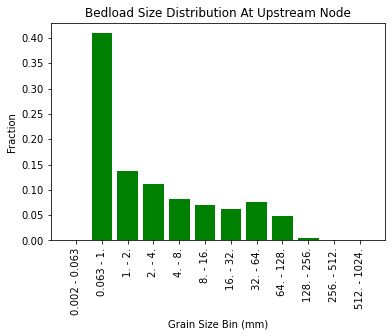

In [56]:
#plot the size distribution of the bedload in the upstream node
fig4 = plot_GSD(Reach.Node[0].Load.GSDBedloadAv,
                "Bedload Size Distribution At Upstream Node")

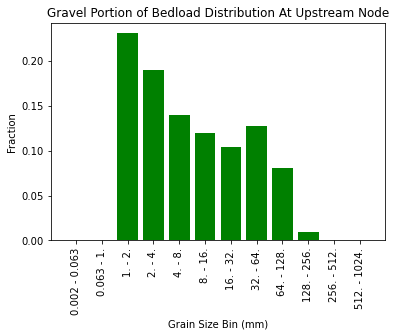

In [57]:
fig5 = plot_GSD(Reach.Node[0].Load.GSDBedloadAv,
                "Gravel Portion of Bedload Distribution At Upstream Node",
                exclude_bins=[1])

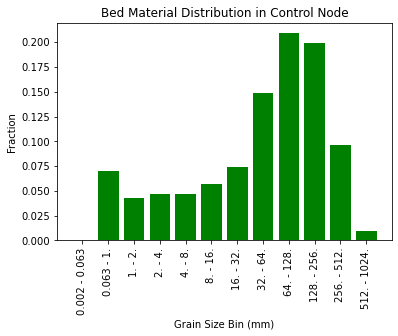

In [58]:
#plot the size distribution of the active layer in the control node
fig6 = plot_GSD(ControlNode.ActiveLayer.GSD, 
                "Bed Material Distribution in Control Node")

## Profile Graphs
It is possible to create along-channel profiles of any node property.  Here, we first define a basic graphing function.

In [59]:
def plot_profile(x,y,graph_title):  
    fig, ax = plt.subplots(1,1)
    ax.plot(x, y)
    plt.xticks(rotation = 90)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(graph_title)
    return fig

Now we use list comprehension to read of the along-channel coordinate and bed elevation for each node in the reach and then call the graphing function with these.

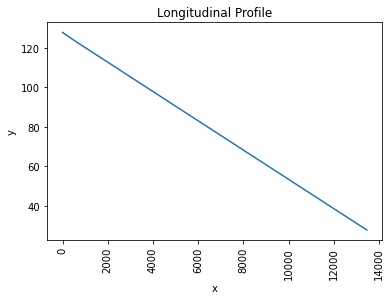

In [60]:
x = [Node.xc for Node in Reach.Node]
y = [Node.etabav for Node in Reach.Node]
fig7 = plot_profile(x,y,"Longitudinal Profile")

The list comprehension can be used to go several levels deep into the node's properties. An along-channel graph of median grain size can be computed as follows:

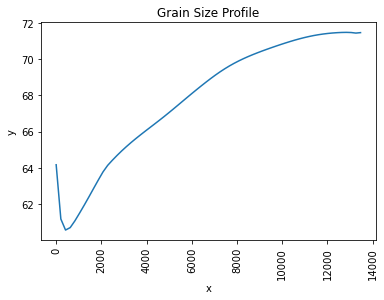

In [61]:
y = [Node.ActiveLayer.GSD.D50 for Node in Reach.Node]
fig8 = plot_profile(x,y,"Grain Size Profile")

## Time Series Graph Generated from Model Output
Model output is saved in the output folder specified in the inputs. The easiest way to access it is by opening the "DailyOutputAsDictionary" file (e.g., using Pandas) and then reading this into a dataframe.

In [70]:
import pandas as pd
df = pd.read_csv(os.path.join(os.pardir, inputs.Outputfolder, "DailyOutput.csv"), 
                              parse_dates=True, 
                              index_col='time_year')
df

,Node[0].DC.Qw[0],Node[-1].DC.Qw[0],Node[10].Load.QsjTot[0],Node[0].CumulativeTotFeed,Node[-1].CumulativeTotFeed,Node[10].Load.QsAvkLoad[0],Node[10].Load.QsAvkLoad[7],Node[10].ActiveLayer.GSD.D50,Node[10].ActiveLayer.ExSed.InWidthChange[1],Node[10].ActiveLayer.ExSed.InWidthChange[7],...,"Node[10].ActiveLayer.T[7,0]","Node[0].Floodplain.T[1,0]","Node[0].Load.TBedFeedk[0,0]","Node[1].Load.TBedFeedk[0,0]","Node[1].ActiveLayer.T[0,0]","Node[0].ActiveLayer.T[0,0]","Node[0].ActiveLayer.T[1,0]",Node[10].FkPointBarDepositAnnualAverage[1],Node[10].Dfav[0],Node[10].Dfav[1]
time_year,,,,,,,,,,,,,,,,,,,,,
2011-09-15,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.004537,0.000133,67.137533,0.0,0.0,...,0.000000e+00,1.000000,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.069651,0.0,0.0
2011-09-16,17.584762,17.584762,1.455877e-06,0.000000,0.000000,0.000000,0.000000,67.137533,0.0,0.0,...,-3.312799e-07,0.999969,0.0,0.0,-3.312799e-07,-3.312799e-07,-3.312799e-07,0.000000,0.0,0.0
2011-09-17,17.216643,17.216643,1.299333e-06,0.000000,0.000000,0.000000,0.000000,67.137533,0.0,0.0,...,-6.625599e-07,0.999937,0.0,0.0,-3.312799e-07,-3.312799e-07,-6.625599e-07,0.000000,0.0,0.0
2011-09-18,16.197236,16.197236,9.349533e-07,0.000000,0.000000,0.000000,0.000000,67.137533,0.0,0.0,...,-9.938398e-07,0.999906,0.0,0.0,-3.312799e-07,-3.312799e-07,-9.938398e-07,0.000000,0.0,0.0
2011-09-19,16.706939,16.706939,1.105764e-06,0.000000,0.000000,0.000000,0.000000,67.137533,0.0,0.0,...,-1.325120e-06,0.999874,0.0,0.0,-3.312799e-07,-3.312799e-07,-1.325120e-06,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-11-10,58.899041,58.899041,4.304800e-04,138778.743381,142545.540436,0.000079,0.000025,63.815971,0.0,0.0,...,4.900059e-01,0.871126,0.0,0.0,-3.312799e-07,-3.312799e-07,2.729812e-03,0.076797,0.0,0.0
2016-11-11,43.041607,43.041607,1.098482e-04,138792.202511,142551.509240,0.000036,0.000005,63.812280,0.0,0.0,...,4.899116e-01,0.871012,0.0,0.0,-3.312799e-07,-3.312799e-07,2.733237e-03,0.076806,0.0,0.0
2016-11-12,36.528732,36.528732,4.960541e-05,138792.202511,142551.509240,0.000000,0.000000,63.812280,0.0,0.0,...,4.899113e-01,0.870935,0.0,0.0,-3.312799e-07,-3.312799e-07,2.732906e-03,0.000000,0.0,0.0


We can now plot any of these series.

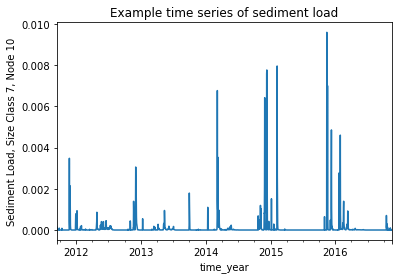

In [93]:
fig9 = df['Node[10].Load.QsAvkLoad[7]'].plot(
    title="Example time series of sediment load", 
    ylabel = "Sediment Load, Size Class 7, Node 10")


## External Post-Run Visulatization Tools
It can be time-consuming to visualize results by hand, so tools have been developed to automate the process. There are two separate programs for accessing and visualizing the model output that is saved at regular intervals.  These are the animation tool and the time series graphing tool.
### Start the animation tool

In [ ]:
%run Animator.py

This should start a widget that allows any of the attributes that were output in step XII.A to be animated on the screen. This could be hidded behind other windows, so look carefully. To use the animator tool, the user must navigate to the output folder that was specified at the beginning of step XII.

### Start the time series graphing tool

In [ ]:
%run ATimeseriesPlotter.py

This should start a widget that allows up to three timeseries withing a given node to be plotted on a three-part figure. The locations and variables where output is available were specified in step XII.A. As with the animator tool, the user must navigate to the output folder that was specified at the beginning of step XII.